<h1>Содержание<span class="tocSkip"></span></h1>


# Проект по классификации новостей на реальные и выдуманные.

На сайте kaggle.com находится данный набор новойстей который можно скачать и, например, построить модель которая сможет определить выдуманная новость или реальная.
Набор состоит из двух файлов:

* Fake.csv (23502 выдуманных новостей)
* True.csv (21417 правдивых новостей)

Dataset columns:

* Title: заголовок новости
* Text:  текст самой новости
* Subject: тип новости
* Date: дата публикации

Для определения качества работы модели будем использовать F1-Score.
* Она учитывает баланс между precision и recall.
* Учитывает оба типа ошибок: False Positive и False Negative

## Подготовка

In [22]:
!pip3 install -q pymystem3
!pip3 install -q transformers
!pip3 install -q scikit-learn
!pip3 install -q catboost
!pip install -q swifter

import swifter

import numpy as np
import pandas as pd
import torch
import transformers
from tqdm import tqdm#notebook
#from tqdm import notebook
import re 
import time
import kagglehub

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer



from pymystem3 import Mystem
#from transformers import BertModel, BertTokenizer
from sklearn.pipeline import Pipeline  # Пайплайн для объединения этапов обработки и обучения
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
#from sklearn.metrics import confusion_matrix

from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score , accuracy_score ,confusion_matrix
from sklearn.model_selection import RandomizedSearchCV#, GridSearchCV  # Автоматический подбор гиперпараметров
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import  StandardScaler  
from sklearn.compose import ColumnTransformer  # Применение разных трансформаций к разным столбцам
from sklearn.impute import SimpleImputer  # Заполнение пропусков в данных

nltk.download('omw-1.4', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)


# Масштабирование и обработка данных
from sklearn.preprocessing import (
    OneHotEncoder,  # Кодирование категориальных признаков методом one-hot
    OrdinalEncoder,  # Кодирование категорий порядковыми номерами
    StandardScaler,  # Нормализация данных
    MinMaxScaler,  # Масштабирование данных в диапазон [0, 1]
    RobustScaler,  # Масштабирование данных устойчиво к выбросам
    LabelEncoder  # Кодирование целевой переменной
)

In [23]:
def clear_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return " ".join((re.sub(r'[^a-zA-Zа-яА-ЯёЁ ]', ' ', text)).split())


def lemmatize(text):
#    m = Mystem()
    cleaned_text = clear_text(text)
    lemm_list = m.lemmatize(cleaned_text)
    lemm_text = "".join(lemm_list)
        
    return lemm_text

In [24]:
def hist_with_stats(df, column, title, xlabel, ylabel, bins,):
    """
    df     - данные
    column - признак по которому строятся графики
    title  - общий заголовок
    bins   - количество бинов для гистограммы
    """

    df=df.loc[df[column].notnull()]
    
    # Вычислим основные статистики
    mean = df[column].mean()
    median = df[column].median()
    mode = df[column].mode()[0]

    # Гистограмма с KDE
    sns.histplot(df[column], bins=bins, kde=True,)
    plt.title(title, fontsize=10)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    
    # Линии для среднего, медианы и моды
    plt.axvline(mean, color='green', linestyle='--', label=f'Среднее = {mean:.2f}')
    plt.axvline(median, color='red', linestyle='-.', label=f'Медиана = {median:.2f}')
    plt.axvline(mode, color='blue', linestyle='-', label=f'Мода = {mode:.2f}')
    plt.legend()

    # Подгоним графики
#    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [25]:
def display_cm(y_real, y_pred):
#  Строим матрицу ошибок
    cm = confusion_matrix(y_real, y_pred)

#  Визуализируем матрицу ошибок
    plt.figure(figsize=(6, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='crest')
    plt.xlabel('Предсказание')
    plt.ylabel('Факт')
    plt.title('Матрица ошибок')
    plt.show()
    return
def show_metrics(y_test, y_pred, round_n=3):
    """

    """
    roc = roc_auc_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    #print(f'Accuracy of Random Forest: {accuracy:.2f}')
    f1 = f1_score(y_test, y_pred)

    print('ROC-AUC =', round(roc,round_n))
    print('Precision =', round(precision,round_n))
    print('Recall =', round(recall,round_n))
    print('Accuracy =', round(accuracy,round_n))
    print('F1_score =', round(f1,round_n))
    return    

### Загрузка данных

In [26]:
try:
    fake_df = pd.read_csv('./kagglehub/clmentbisaillon/fake-and-real-news-dataset/Fake.csv')
    true_df = pd.read_csv('./kagglehub/clmentbisaillon/fake-and-real-news-dataset/True.csv')
    print('Load localy')
except:
    path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")
    print("Path to dataset files:", path)
    
    fake_df = pd.read_csv(path+'/Fake.csv')
    true_df = pd.read_csv(path+'/True.csv')
    print('Load from www')

fake_df['is_fake'] = 1    # добавим характерный признак
true_df['is_fake'] = 0    # добавим характерный признак

#fake_df = fake_df.sample(8000).reset_index(drop=True)
#true_df = true_df.sample(8000).reset_index(drop=True)



Load localy


Посмотрим что скачалось.

In [27]:
fake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
 4   is_fake  23481 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 917.4+ KB


В наборе выдуманных новостей содержится 23481 запись. Есть все заявленные поля:
* Title: заголовок новости
* Text: текст самой новости
* Subject: тип новости
* Date: дата публикации
Так же присутствует добавленный признак
* is_fake: 1- признак выдуманной записи

In [28]:
true_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
 4   is_fake  21417 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 836.7+ KB


В наборе выдуманных новостей содержится 21417 запись. Есть все заявленные поля:
* Title: заголовок новости
* Text: текст самой новости
* Subject: тип новости
* Date: дата публикации
Так же присутствует добавленный признак
* is_fake: 0 - признак реальной записи

Объединим два набора данных в один для последующего анализа.

In [29]:
df_news = pd.concat([fake_df, true_df], axis=0)
df_news = df_news.reset_index(drop=True)

Сделаем признак subject категорийным. Это любят некоторые модели.

In [30]:
df_news['subject'] = df_news['subject'].astype('category')

Преобразуем текстовую дату в цифровую

In [31]:
def to_date(text_date):
    """
    Простая функция преобразования даты с обработкой ошибок
    """
    try:
        return pd.to_datetime(text_date)
    except:
        return pd.to_datetime('01-01-1900') # защищаемся от "плохих" данных

# Самый простой способ - pandas сам попробует определить формат
df_news['real_date'] = df_news['date'].apply(to_date)

df_news['year'] = df_news['real_date'].dt.year.astype('int32')
df_news['month'] = df_news['real_date'].dt.month.astype('int32')
df_news['day'] = df_news['real_date'].dt.day.astype('int32')
df_news['day_of_week'] = df_news['real_date'].dt.dayofweek.astype('int32')
#df_news['is_weekend'] = df_news['day_of_week'].isin([5, 6])


Т.к. даты записаны в разных форматах, пришлось использовать .apply .

In [32]:
display(df_news.sample(10))
display(df_news.info())

,title,text,subject,date,is_fake,real_date,year,month,day,day_of_week
27446,Trump questions why U.S. Civil War had to happen,WASHINGTON (Reuters) - Donald Trump has shown ...,politicsNews,"May 1, 2017",0,2017-05-01,2017,5,1,0
14707,PRICELESS: Watch Bill Clinton’s Awkward Respon...,Let s be honest when it comes to the Clinton c...,politics,"Jan 4, 2016",1,2016-01-04,2016,1,4,0
19260,ANTI-TRUMP RADICAL Taunts TRUMP Supporters Wit...,This really shouldn t be surprising for anyon...,left-news,"Jan 22, 2017",1,2017-01-22,2017,1,22,6
36887,"Israeli, Palestinian killed in two violent inc...",JERUSALEM (Reuters) - An Israeli and a Palesti...,worldnews,"November 30, 2017",0,2017-11-30,2017,11,30,3
36896,"U.N. extends Syria round to Dec. 15, presidenc...",GENEVA (Reuters) - The United Nations said on ...,worldnews,"November 30, 2017",0,2017-11-30,2017,11,30,3
32351,Clinton expands lead over Trump to 13 points: ...,NEW YORK (Reuters) - Democratic presidential c...,politicsNews,"July 5, 2016",0,2016-07-05,2016,7,5,1
9094,CELEBRATE! TRUMP HIGHLIGHT Video From “Year On...,The conservative 45Committee is out with a new...,politics,"Dec 30, 2017",1,2017-12-30,2017,12,30,5
21680,TAXPAYER FUNDED OPERATION CONSERVATIVE TAKE DO...,How many American taxpayer dollars have alread...,left-news,"Jun 1, 2015",1,2015-06-01,2015,6,1,0
15839,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,1,1900-01-01,1900,1,1,0
16832,BOMBSHELL: U.S.DEFENSE SECRETARY ADMITS Obama ...,"No wonder Obama didn t offer up a prayer, or u...",Government News,"Jan 15, 2016",1,2016-01-15,2016,1,15,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   title        44898 non-null  object        
 1   text         44898 non-null  object        
 2   subject      44898 non-null  category      
 3   date         44898 non-null  object        
 4   is_fake      44898 non-null  int64         
 5   real_date    44898 non-null  datetime64[ns]
 6   year         44898 non-null  int32         
 7   month        44898 non-null  int32         
 8   day          44898 non-null  int32         
 9   day_of_week  44898 non-null  int32         
dtypes: category(1), datetime64[ns](1), int32(4), int64(1), object(3)
memory usage: 2.4+ MB


None

Дата преобразована и все новые поля видны.

Проверим наличие записей с датой 1900 года. 

In [33]:
display(df_news.loc[df_news['year'] == 1900])

,title,text,subject,date,is_fake,real_date,year,month,day,day_of_week
9358,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,https://100percentfedup.com/served-roy-moore-v...,1,1900-01-01,1900,1,1,0
15507,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,politics,https://100percentfedup.com/video-hillary-aske...,1,1900-01-01,1900,1,1,0
15508,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,politics,https://100percentfedup.com/12-yr-old-black-co...,1,1900-01-01,1900,1,1,0
15839,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,1,1900-01-01,1900,1,1,0
15840,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,1,1900-01-01,1900,1,1,0
17432,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,1,1900-01-01,1900,1,1,0
17433,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,1,1900-01-01,1900,1,1,0
18933,Homepage,[vc_row][vc_column width= 1/1 ][td_block_trend...,left-news,MSNBC HOST Rudely Assumes Steel Worker Would N...,1,1900-01-01,1900,1,1,0
21869,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,1,1900-01-01,1900,1,1,0
21870,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,1,1900-01-01,1900,1,1,0


Очевидная ошибка ввода данных. Просто удалим все записи где вместо даты были гиперссылки или другой текстовый мусор

In [34]:
df_news = df_news.loc[df_news['year'] != 1900]

Данные успешно загружены.
Пропусков на данном этапе не обнаружено.

In [35]:
def lemmatize_with_limits(text, limits_tokens = 500):
    """

    """
#    if len(text) <= 1:
#        text = 'no text'
        
    cleaned_text = clear_text(text)
#    lemmatizer = WordNetLemmatizer()
    # Конвертируем POS-теги NLTK в формат WordNet
    pos_map = {'J': 'a', 'N': 'n', 'V': 'v', 'R': 'r'}  # Adjective, Noun, Verb, Adverb
    tokens = word_tokenize(cleaned_text)

    if len(tokens) > limits_tokens:
        tokens = tokens[:limits_tokens]

    
    pos_tags = pos_tag(tokens)
    
    lemmas = []
    for word, tag in pos_tags:
        pos = pos_map.get(tag[0], 'n')  # По умолчанию 'n' (существительное)
        lemmas.append(lemmatizer.lemmatize(word, pos=pos))
    
    return ' '.join(lemmas)


### Итог этапа подготовки данных

* Закачен набор данных с обманными новостями содержащий 23481 записей
* Закачен набор данных с правдивыми новостями содержащий 21417 записей
* Оба набора данных объеденены в один набор с 44898 записями.
* Всем новостям добавлен признак **is_fake** указывающий на исходный набор данных. 1=fake. 0=true.
* Признак **date** из текстового формата переведён в формат даты - **real_date**
* Удалено несколько записей с гиперссылками вместо текста и даты.
* Признак **subject** сделан категорией.

## Анализ данных

### Проверим данные на дубли

In [36]:
duplicates_text = df_news.loc[df_news.duplicated(subset=["text"], keep=False)]
print("twins news :", duplicates_text.shape)
print("Дубликаты в тексте:")
display(duplicates_text[['title', 'text','is_fake']].head(10))

# Дубликаты по столбцу 'name'
duplicates_title = df_news.loc[df_news.duplicated(subset=['title'], keep=False)]
print("twins news :", duplicates_text.shape)
print("Дубликаты в заголовках:")
display(duplicates_title[['title', 'text','is_fake']].tail(10))


twins news : (11386, 10)
Дубликаты в тексте:


,title,text,is_fake
9087,BARBRA STREISAND Gives Up On Dream Of Impeachi...,Barbra Streisand was an Obama sycophant and on...,1
9088,WATCH: SENATOR LINDSEY GRAHAM DROPS BOMBSHELL…...,Everyone suspected the sketchy Steele Dossier ...,1
9089,“CONSERVATIVE GAY GUY” BLASTS Pence’s Aspen Ne...,It s been said that good fences make good neig...,1
9091,BILL NYE The FAKE Science Guy THREATENS Conser...,"Friday on MSNBC, climate activist Bill Nye war...",1
9093,EMBARRASSING: Anti-Trump “THE HILL” Gets SLAMM...,"#JokeNewsAfter record, cold temperatures were ...",1
9095,IT ONLY TOOK ONE TWEET FROM PRESIDENT TRUMP Fo...,A week after President Trump endorsed Ron DeSa...,1
9096,WATCH HERO Singlehandedly Shut Down Anti-Trump...,The video below is one of the highlights from ...,1
9097,FINALLY RELEASED! Email from Huma Abedin Inclu...,"Thanks to the persistence of Judicial Watch, t...",1
9106,CNN’S FAKE NEWS BACKFIRES! CNN Legal Analyst A...,Hell has frozen over! CNN is actually reportin...,1
9107,WHY THIS Democrat Stronghold County Voted For ...,AP News The regulars amble in before dawn and...,1


twins news : (11386, 10)
Дубликаты в заголовках:


,title,text,is_fake
44812,New sanctions aim to restrict Venezuela access...,WASHINGTON (Reuters) - U.S. Treasury Secretary...,0
44826,Thailand's ousted PM Yingluck has fled abroad:...,BANGKOK (Reuters) - Ousted Thai prime minister...,0
44834,Thailand's ousted PM Yingluck has fled abroad:...,BANGKOK (Reuters) - Ousted Thai prime minister...,0
44837,"Trump calls Egypt's Sisi, says keen to overcom...",CAIRO (Reuters) - U.S. President Donald Trump ...,0
44883,Exclusive: Trump's Afghan decision may increas...,ON BOARD A U.S. MILITARY AIRCRAFT (Reuters) - ...,0
44884,U.S. puts more pressure on Pakistan to help wi...,WASHINGTON (Reuters) - The United States sugge...,0
44886,Trump talks tough on Pakistan's 'terrorist' ha...,ISLAMABAD (Reuters) - Outlining a new strategy...,0
44887,"U.S., North Korea clash at U.N. forum over nuc...",GENEVA (Reuters) - North Korea and the United ...,0
44889,"U.S., North Korea clash at U.N. forum over nuc...",GENEVA (Reuters) - North Korea and the United ...,0
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,0


11386 дублей.
Видно что у дублей обычно одинаковая пара полей 'title', 'text'.

Удалим все дубли в признаке text.

In [102]:
df_clean = df_news.drop_duplicates(subset=["text"], keep='first').reset_index(drop=True)

In [103]:
display(df_clean.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38640 entries, 0 to 38639
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   title        38640 non-null  object        
 1   text         38640 non-null  object        
 2   subject      38640 non-null  category      
 3   date         38640 non-null  object        
 4   is_fake      38640 non-null  int64         
 5   real_date    38640 non-null  datetime64[ns]
 6   year         38640 non-null  int32         
 7   month        38640 non-null  int32         
 8   day          38640 non-null  int32         
 9   day_of_week  38640 non-null  int32         
dtypes: category(1), datetime64[ns](1), int32(4), int64(1), object(3)
memory usage: 2.1+ MB


None

### Посмотрим на целевой признак

In [92]:
df_clean['is_fake'].value_counts()

is_fake
0    21191
1    17449
Name: count, dtype: int64

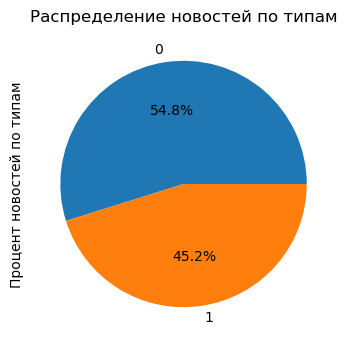

In [101]:
df_clean['is_fake'].value_counts().plot(kind='pie', 
                                        x='is_fake', 
                                        xlabel = 'Тип новости',
                                        ylabel = 'Процент новостей по типам',
                                        title = 'Распределение новостей по типам', 
                                        figsize=(5, 4),
                                        autopct='%1.1f%%'б
                                        
                                          );

Довольно равномерно распределён целевой признак. 54.8% - правдивых новостей и  45.2% выдуманных. Дисбаланса нет.

### Займёмся леммами

In [39]:
tqdm.pandas()
#m = Mystem() 
lemmatizer = WordNetLemmatizer()

Сделаем дополнительные признаки на основе скаченных признаков 'text' и 'title'. В функции **lemmatize_with_limits** установим ограничение что учитывать первые 500 слов. Если сообщение больше - функция возьмёт только первую 500 слов, а остальное отбросит. Это связано с тем что основная мысль сообщения обычно находится в первых 100-200 словах. Некоторые люди дальше просто не читают. Для надёжности будет учитывать первые 500 слов. Значит можно отбросить всё что находится за этим ограничением . Это уменьшит время обучения и снизит вероятность переобучения моделей.

In [40]:
%%time
print('Начинаем.')
try: 
#    df_news['clean_lemma'] = df_news['text'].progress_apply(lemmatize_with_limits)
#    df_news['clean_lemma_title'] = df_news['title'].progress_apply(lemmatize_with_limits)    
    df_clean['clean_lemma'] = df_clean['text'].swifter.progress_bar().apply(lemmatize_with_limits)
    df_clean['clean_lemma_title'] = df_clean['title'].swifter.progress_bar().apply(lemmatize_with_limits)
except:
    df_clean['clean_lemma'] = df_clean['text'].apply(lemmatize_with_limits)
    df_clean['clean_lemma_title'] = df_clean['title'].apply(lemmatize_with_limits)
    print("Красивый swifter недоступен, использован обычный apply()")

Начинаем.


Pandas Apply:   0%|          | 0/38640 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/38640 [00:00<?, ?it/s]

CPU times: user 6min 36s, sys: 1.93 s, total: 6min 38s
Wall time: 6min 36s


In [41]:
display(df_clean.sample(n=10))

,title,text,subject,date,is_fake,real_date,year,month,day,day_of_week,clean_lemma,clean_lemma_title
38629,Trump talks tough on Pakistan's 'terrorist' ha...,ISLAMABAD (Reuters) - Outlining a new strategy...,worldnews,"August 22, 2017",0,2017-08-22,2017,8,22,1,islamabad reuters outline a new strategy for t...,trump talk tough on pakistan s terrorist haven...
11602,SIT DOWN AND SHUT UP! Senator Whack-Job Warren...,Senate Majority Leader Mitch McConnell shut do...,politics,"Feb 8, 2017",1,2017-02-08,2017,2,8,2,senate majority leader mitch mcconnell shut do...,sit down and shut up senator whack job warren ...
8524,Carly Fiorina LOSES IT After The ‘Baby Parts’...,You have to admire conservatives ability to c...,News,"January 26, 2016",1,2016-01-26,2016,1,26,1,you have to admire conservative ability to com...,carly fiorina loses it after the baby part peo...
14225,GERMANY CRISIS ESCALATES: Muslim Migrants Mast...,What a great place to take the whole family!We...,politics,"Jan 22, 2016",1,2016-01-22,2016,1,22,4,what a great place to take the whole family we...,germany crisis escalate muslim migrant masturb...
21503,Justice Department antitrust nominee Makan Del...,WASHINGTON (Reuters) - The confirmation testim...,politicsNews,"April 26, 2017",0,2017-04-26,2017,4,26,2,washington reuters the confirmation testimony ...,justice department antitrust nominee makan del...
17555,Trump judicial nominee withdraws from consider...,WASHINGTON (Reuters) - A lawyer nominated by P...,politicsNews,"December 18, 2017",0,2017-12-18,2017,12,18,0,washington reuters a lawyer nominate by presid...,trump judicial nominee withdraws from consider...
34913,U.S. to withdraw from U.N.'s cultural agency i...,WASHINGTON (Reuters) - The United States is wi...,worldnews,"October 12, 2017",0,2017-10-12,2017,10,12,3,washington reuters the united state be withdra...,u s to withdraw from u n s cultural agency in ...
21605,Trump asks for probe into imports of foreign-m...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 20, 2017",0,2017-04-20,2017,4,20,3,washington reuters u s president donald trump ...,trump asks for probe into import of foreign ma...
35861,"Weak columns, extra floors led to Mexico schoo...",MEXICO CITY (Reuters) - A Mexico City school t...,worldnews,"September 30, 2017",0,2017-09-30,2017,9,30,5,mexico city reuters a mexico city school that ...,weak column extra floor lead to mexico school ...
20524,Moscow cancels meeting with U.S. diplomat afte...,MOSCOW/WASHINGTON (Reuters) - Angered by expan...,politicsNews,"June 21, 2017",0,2017-06-21,2017,6,21,2,moscow washington reuters anger by expanded u ...,moscow cancel meet with u s diplomat after san...


Подсчитаем количество символов и количество слов в тексте новостей и заголовках.

In [42]:
#Создаем столбец с длиной каждого сообщения
try: 
    df_clean['message_length_text'] = df_clean['clean_lemma'].progress_apply(lambda x: len(x))
    df_clean['message_length_title'] = df_clean['clean_lemma_title'].progress_apply(lambda x: len(x))
except:
    df_clean['message_length_text'] = df_clean['clean_lemma'].apply(lambda x: len(x))
    df_clean['message_length_title'] = df_clean['clean_lemma_title'].apply(lambda x: len(x))
    print("progress_apply недоступен, использован обычный apply()")
#Посчитаем количество слов в сообщении
df_clean['words_count_text'] = df_clean['clean_lemma'].copy().str.split().str.len().values
df_clean['words_count_title'] = df_clean['clean_lemma_title'].copy().str.split().str.len().values    

Pandas Apply:   0%|          | 0/38640 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/38640 [00:00<?, ?it/s]

In [43]:
df_sampled = df_clean.sample(n=1000)

In [44]:
df_sampled['subject'].value_counts()

subject
politicsNews       302
worldnews          271
News               231
politics           163
US_News             17
Government News     11
left-news            5
Middle-east          0
Name: count, dtype: int64

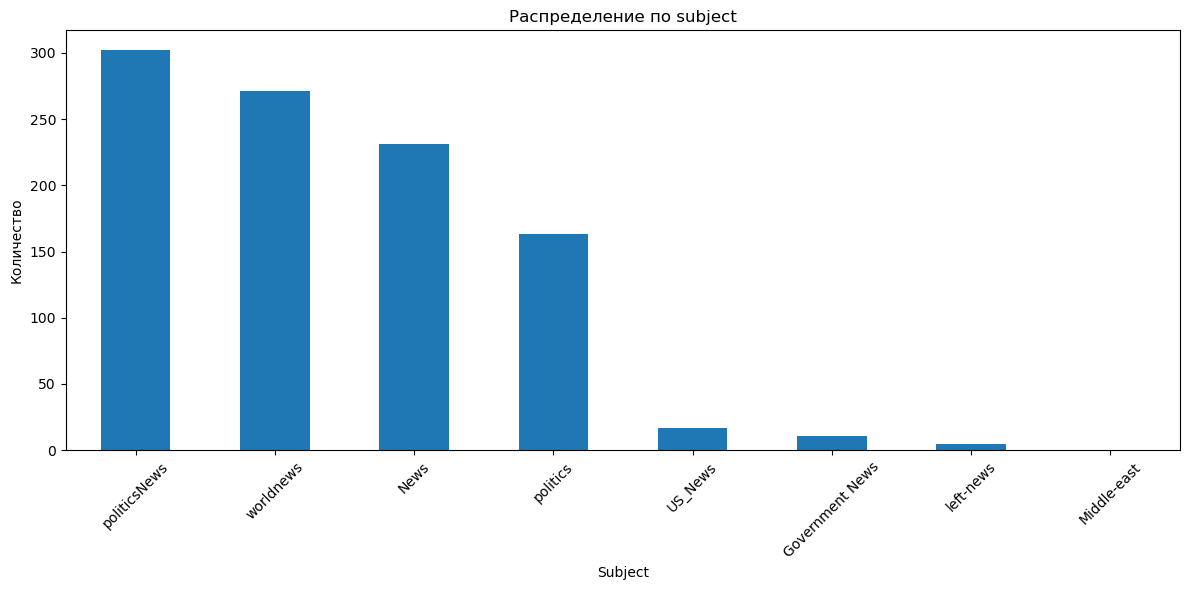

In [45]:
# Базовый bar plot
plt.figure(figsize=(12, 6))
df_sampled['subject'].value_counts().plot(kind='bar')
plt.title('Распределение по subject')
plt.xlabel('Subject')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Обнаружено 8 вариантов в признаке **subject**. Самые крупные из них: 
* politicsNews
* worldnews
* News
* politics.

### Посмотрим статистику по тексту

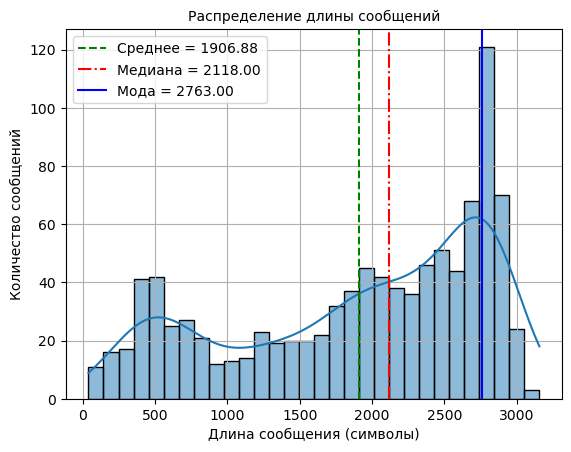

In [46]:
hist_with_stats(df_sampled, 'message_length_text','Распределение длины сообщений', 'Длина сообщения (символы)', 'Количество сообщений',  30)

Наблюдаетя правосторонняя асимметрия. Длинна сообщений находится в интервале от 0 до 31336 символов.
* Мода - 2763 символа
* Медиана - 2118 символов

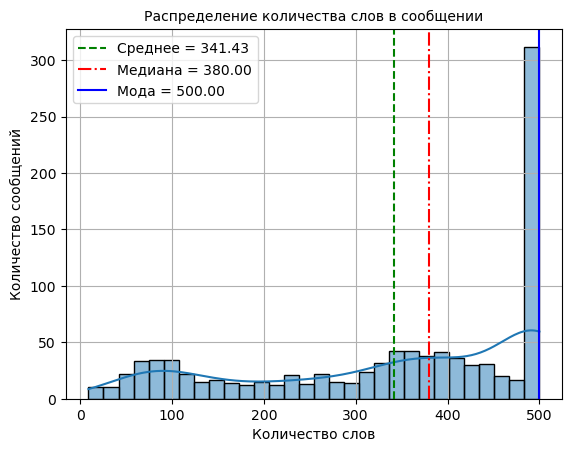

In [47]:
hist_with_stats(df_sampled, 'words_count_text','Распределение количества слов в сообщении', 'Количество слов', 'Количество сообщений',  30)

Наблюдаетя довольно равномерное распределение. Виден большое количество слов в новостяз ограниченных лимитом в 500 слов.
* Мода - 500 слов
* Медиана - 380 слов

### Посмотрим статистику по заголовкам

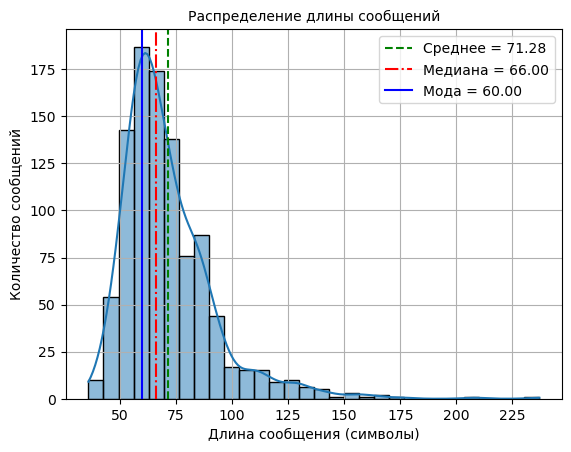

In [48]:
hist_with_stats(df_sampled, 'message_length_title','Распределение длины сообщений', 'Длина сообщения (символы)', 'Количество сообщений',  30)

Распределение похоже на нормальное, сдвинуто влево. Длина заголовков находится в интервале  от 36 до 237 символов.
* Мода - 60 символа
* Медиана - 66 символов

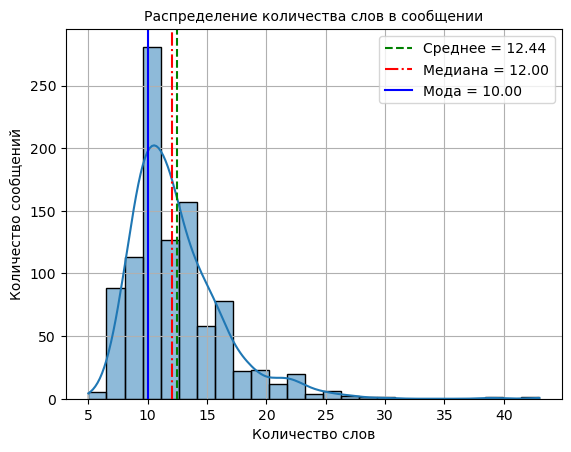

In [49]:
hist_with_stats(df_sampled, 'words_count_title','Распределение количества слов в сообщении', 'Количество слов', 'Количество сообщений',  25)

In [111]:
#display(df_sampled.head(10))

### Посмотрим статистику по датам

In [51]:
def hist_2_sets_density(df,column_for_paining, column_for_filtering, filter_1, filter_2, set1_label, set2_label , bins=30):    
    """
    Строит гистограмму по одному из признаков. 
    Фильтрация происходит по другому БИНАРНОМУ признаку. 
    Значения двух набород данных выравниваются .
    
    Args
        df                   # Набор данных
        column_for_paining   # По какому признаку строим график
        column_for_filtering # По какому признаку разделяем по цветам
        filter_1             # Условие отбора для первого нобора
        filter_2             # Условие отбора для второго набора
        set1_label           # Название первого набора
        set2_label           # Название второго набора
        bins                 # Количество корзин на графике
    Returns 
    """
    set1 = df[column_for_paining].loc[df[column_for_filtering] == filter_1]
    set2 = df[column_for_paining].loc[df[column_for_filtering] == filter_2]
    plt.figure(figsize=(9, 4), constrained_layout=True)
    
    plt.hist(
        [set1, set2], 
        bins = bins , 
        density=True, 
#        common_norm=False, 
        label=[set1_label, set2_label],
    )
    
    plt.legend(loc='upper right')
    plt.title(column_for_paining)
    plt.ylabel('Распределение')
    plt.xlabel(column_for_paining)
    plt.show()
    return

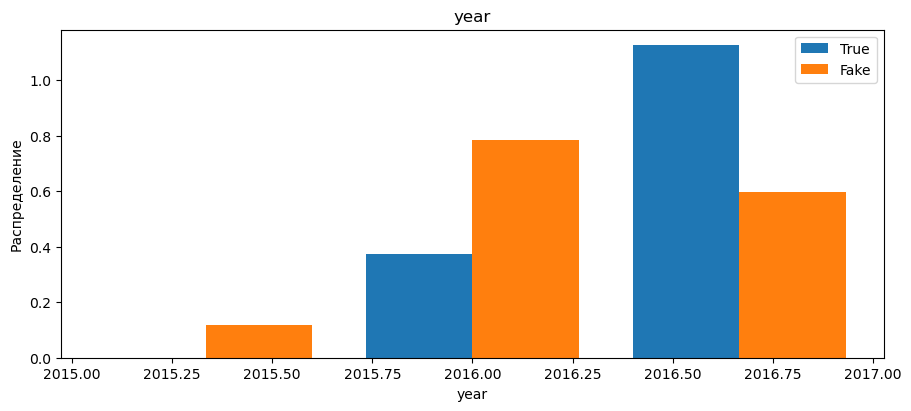

In [56]:
hist_2_sets_density(df_sampled.loc[df_sampled['year'] != 1900],      #                         # Набор данных
            'year',   #  column_for_paining     # По какому признаку строим график
            'is_fake',            #  column_for_filtering   # По какому признаку разделяем по цветам
            0,                #  filter_1               # Условие отбора для первого нобора
            1,                 #  filter_2               # Условие отбора для второго набора
            'True',         #  set1_label             # Название первого набора
            'Fake',           #  set2_label             # Название второго набора
              3,              # bins                 # Количество корзин на графике
           ) 

* Интересно что за 2015 год практически одни придуманные новости.
* В 2016 году выдуманных новостей в 2 раза больше чем реальных.
* В 2017 году реальных новостей в 2 раза больше чем выдуманных


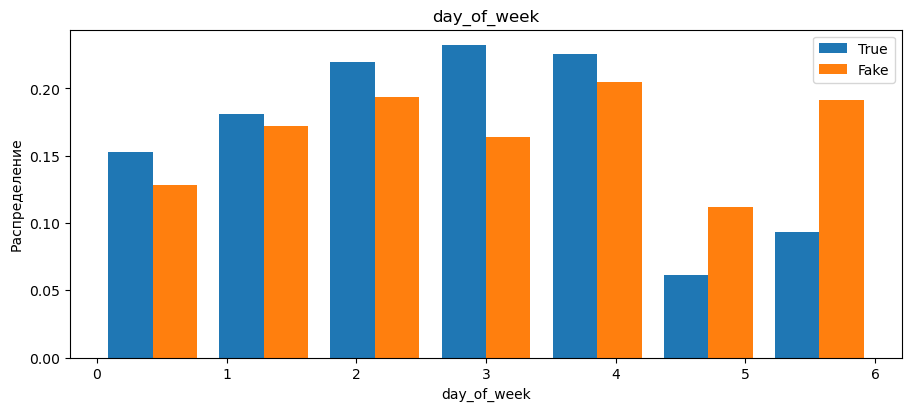

In [57]:
hist_2_sets_density(df_sampled.loc[df_sampled['year'] != 1900],      #                         # Набор данных
            'day_of_week',   #  column_for_paining     # По какому признаку строим график
            'is_fake',            #  column_for_filtering   # По какому признаку разделяем по цветам
            0,                #  filter_1               # Условие отбора для первого нобора
            1,                 #  filter_2               # Условие отбора для второго набора
            'True',         #  set1_label             # Название первого набора
            'Fake',           #  set2_label             # Название второго набора
             7 ,              # bins                 # Количество корзин на графике
           ) 

Видно что в пятницу и субботу выдуманных новостей в 2 раза больше чем реальных. В остальные дни реальных новостей на 5-15% больше чем придуманных.

Посмотрим общую статистику по численным признакам

In [58]:
df_sampled.describe()

,is_fake,real_date,year,month,day,day_of_week,message_length_text,message_length_title,words_count_text,words_count_title
count,1000.00000,1000,1000.00000,1000.000000,1000.0000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.42700,2017-02-18 02:06:43.200000,2016.56600,7.325000,15.9110,2.827000,1906.877000,71.282000,341.431000,12.435000
min,0.00000,2015-04-04 00:00:00,2015.00000,1.000000,1.0000,0.000000,40.000000,36.000000,9.000000,5.000000
25%,0.00000,2016-07-27 18:00:00,2016.00000,4.000000,8.0000,1.000000,1219.750000,58.000000,222.500000,10.000000
50%,0.00000,2017-03-26 12:00:00,2017.00000,8.000000,16.0000,3.000000,2118.000000,66.000000,380.000000,12.000000
75%,1.00000,2017-10-06 12:00:00,2017.00000,11.000000,23.0000,4.000000,2698.000000,80.000000,500.000000,14.000000
max,1.00000,2017-12-29 00:00:00,2017.00000,12.000000,31.0000,6.000000,3156.000000,237.000000,500.000000,43.000000
std,0.49489,NaN,0.56032,3.588628,8.6815,1.836421,870.287093,20.783032,155.786683,3.912938


* признак **year** находится в интервале 2015-2017
* Представлены все месяцы и все дни месяцев.
* признак **day_of_week** находится в интервале 0-6. Представленны все дни недели.

### Посмотрим статистику по словам

In [59]:
from wordcloud import WordCloud

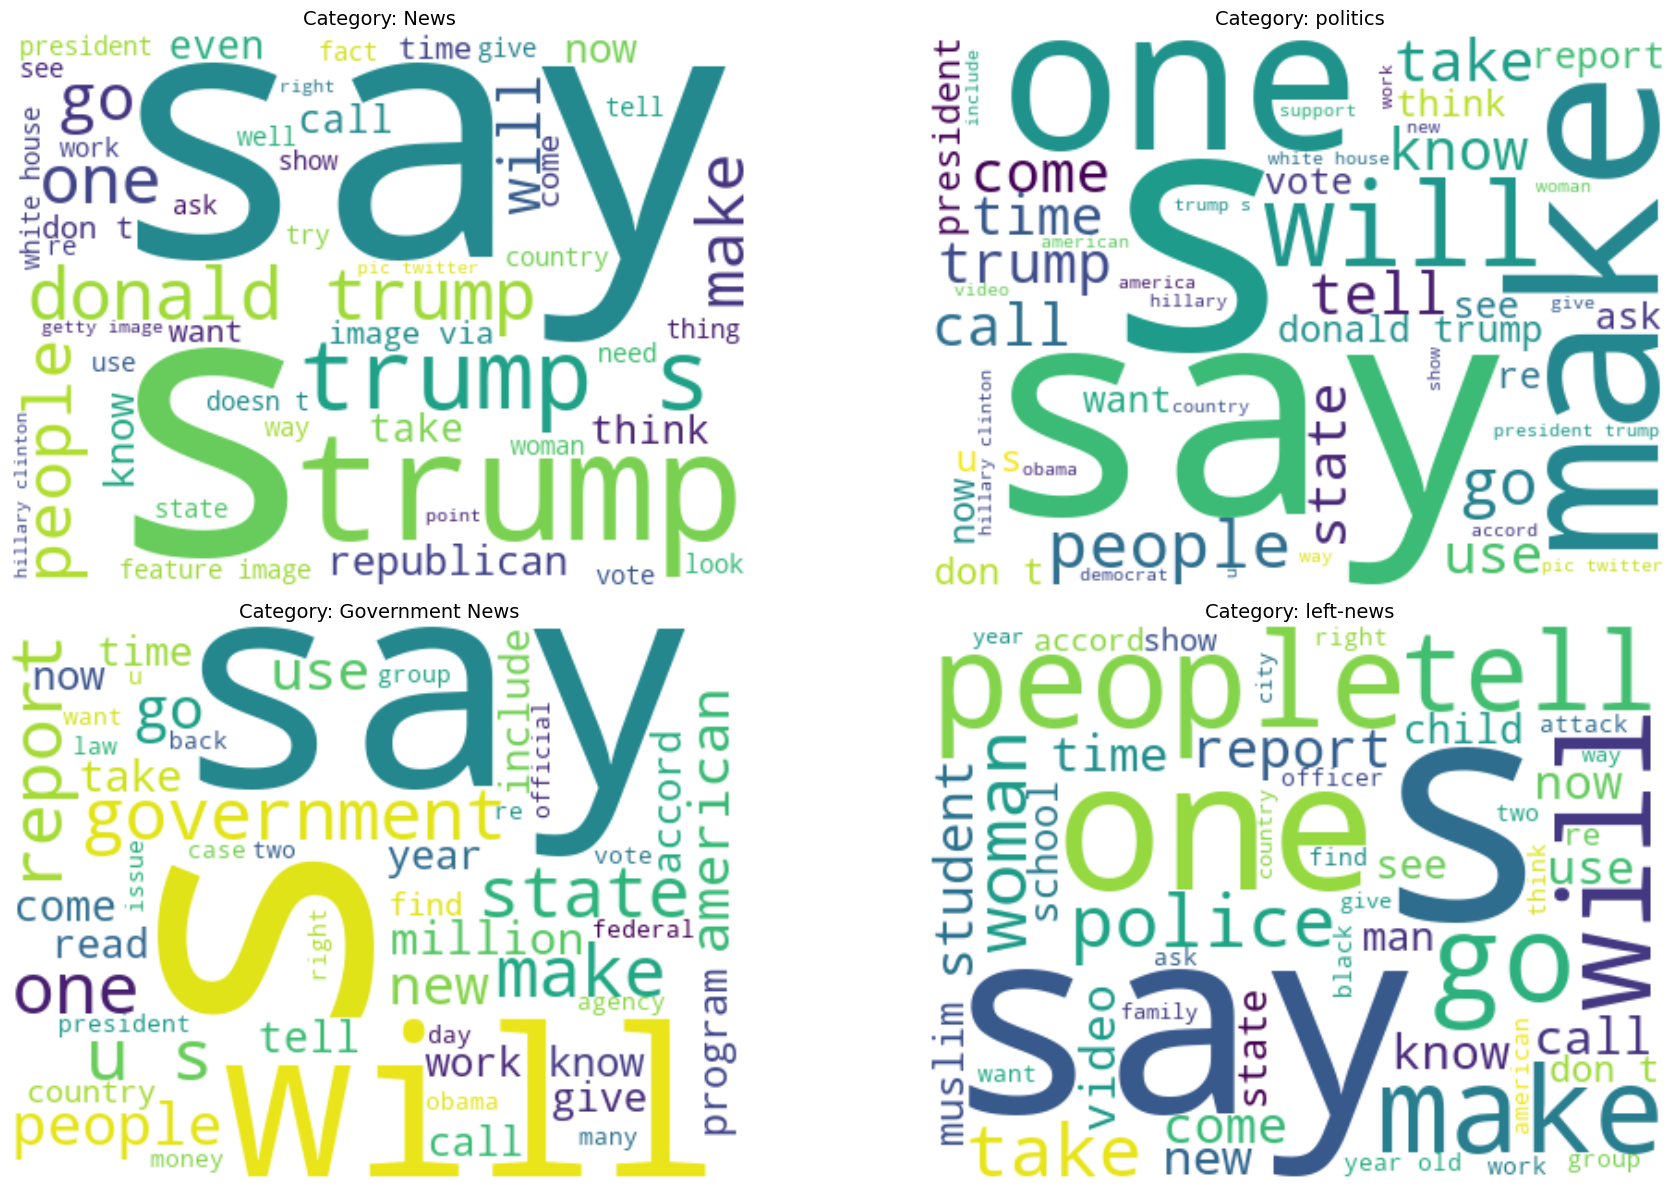

In [61]:
categories = df_news['subject'].unique()

fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = axes.flatten()

for i, category in enumerate(categories[:4]):  # первые 6 категорий
    category_text = " ".join(
        df_clean[df_clean['subject'] == category]['clean_lemma'].dropna().astype(str)
    )
    
    if category_text.strip():
        wc = WordCloud(
            width=400,
            height=300,
            background_color='white',
            max_words=50
        ).generate(category_text)
        
        axes[i].imshow(wc, interpolation='bilinear')
        axes[i].set_title(f'Category: {category}', fontsize=14)
        axes[i].axis('off')

plt.tight_layout()
plt.show()

На первом месте или SAY .

In [63]:
def word_counts_func(text):

# Создаем векторщик для униграмм (отдельных слов)
    uni_vectorizer = CountVectorizer(ngram_range=(1, 1), stop_words='english')  # только 1-граммы
    X_uni = uni_vectorizer.fit_transform(df_clean['clean_lemma'].sample(n=15000))

# Получаем частоты слов
    word_counts = pd.DataFrame(
        X_uni.toarray(),
        columns=uni_vectorizer.get_feature_names_out()
    ).sum().sort_values(ascending=False)
    return word_counts

word_counts = word_counts_func(df_clean['clean_lemma'].sample(n=1500))
print("Топ-10 популярных слов:")
print(word_counts.head(10))

Топ-10 популярных слов:
say           49245
trump         41218
state         17916
president     17393
people        11903
republican    11832
year          11697
make          10763
reuters       10483
donald         9314
dtype: int64


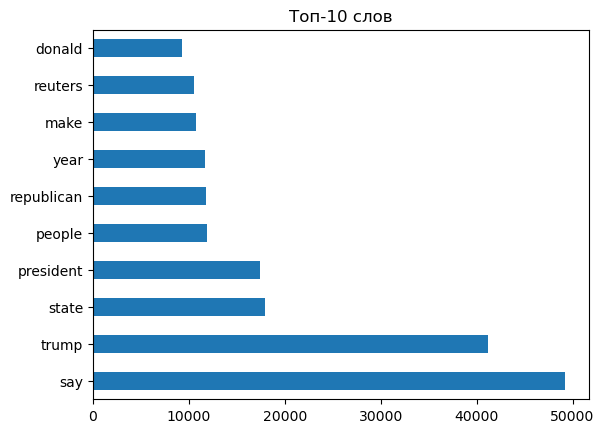

In [64]:
# Для униграмм
word_counts.head(10).plot(kind='barh', title='Топ-10 слов')
plt.show()

del word_counts

In [65]:
def bigram_counts_func(text):
# Векторщик для биграмм
    bi_vectorizer = CountVectorizer(ngram_range=(2, 2),stop_words='english')  # только 2-граммы
    X_bi = bi_vectorizer.fit_transform(text)

# Частоты биграмм
    bigram_counts = pd.DataFrame(
        X_bi.toarray(),
        columns=bi_vectorizer.get_feature_names_out()
    ).sum().sort_values(ascending=False)
    return bigram_counts



In [107]:
bigram_counts_fake = bigram_counts_func(df_clean['text'].loc[df_clean['is_fake'] == 1].sample(n=4000))
bigram_counts_true = bigram_counts_func(df_clean['text'].loc[df_clean['is_fake'] == 1].sample(n=4000))

In [109]:
display(bigram_counts_fake.head(20))

donald trump             3247
featured image           1814
hillary clinton          1286
twitter com              1211
white house              1205
united states            1155
pic twitter              1145
getty images              955
president obama           785
new york                  732
fox news                  650
president trump           562
year old                  476
trump campaign            401
trump realdonaldtrump     373
barack obama              369
supreme court             350
fake news                 346
screen capture            332
trump said                323
dtype: int64

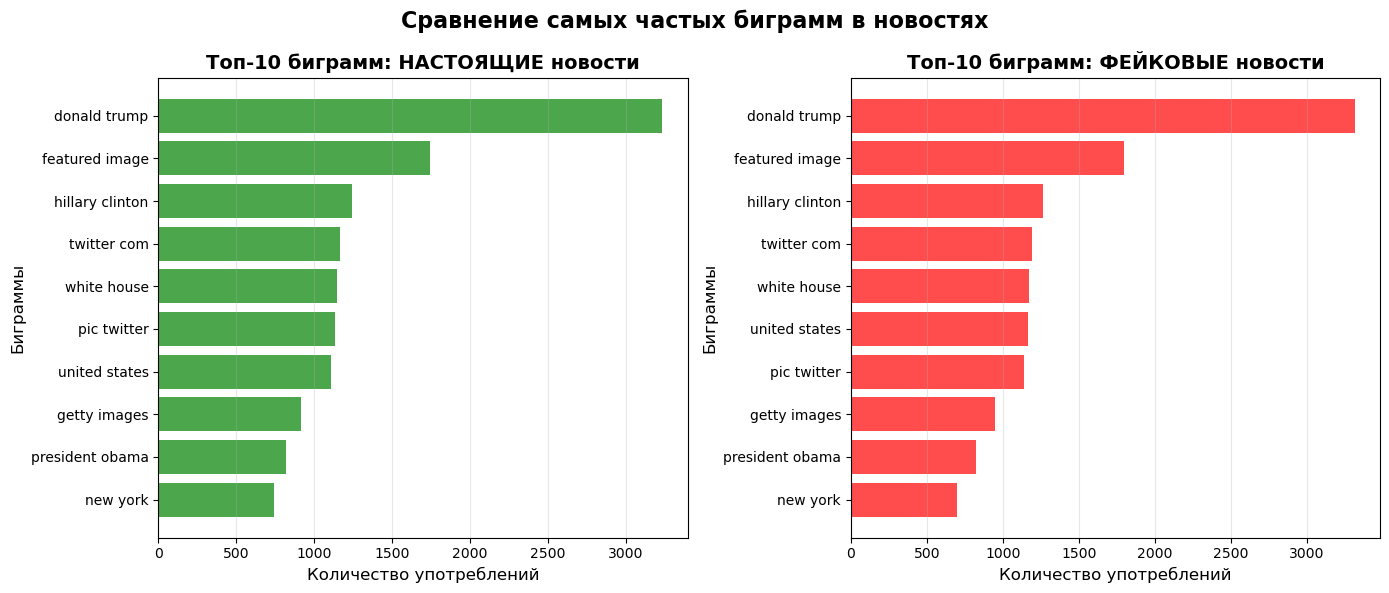

In [69]:
# Создаем фигуру и располагаем два графика рядом горизонтально
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Первый график 
true_plot = bigram_counts_true.head(10)
ax1.barh(true_plot.index, true_plot.values, color='green', alpha=0.7)
ax1.set_title('Топ-10 биграмм: НАСТОЯЩИЕ новости', fontsize=14, fontweight='bold')
ax1.set_xlabel('Количество употреблений', fontsize=12)
ax1.set_ylabel('Биграммы', fontsize=12)
ax1.invert_yaxis()  #сортировка
ax1.grid(axis='x', alpha=0.3)

# Второй график
fake_plot = bigram_counts_fake.head(10)
ax2.barh(fake_plot.index, fake_plot.values, color='red', alpha=0.7)
ax2.set_title('Топ-10 биграмм: ФЕЙКОВЫЕ новости', fontsize=14, fontweight='bold')
ax2.set_xlabel('Количество употреблений', fontsize=12)
ax2.set_ylabel('Биграммы', fontsize=12)
ax2.invert_yaxis()  
ax2.grid(axis='x', alpha=0.3)

# Общий заголовок
plt.suptitle('Сравнение самых частых биграмм в новостях', fontsize=16, fontweight='bold')

# Улучшаем расположение
plt.tight_layout()
plt.show()

Видно что набор биграмм в реальных и выдуманных новостях одинаковый, немного меняются места. На первом месте в обоих группах, с большим отрывом  расположен 'Donald Trump'.

In [70]:
del bigram_counts_fake
del bigram_counts_true

### Итог этапа анализа данных

* В признаке **subject** присутствует 8 категорий. Самые крупные из них: worldnews, politicsNews, News, politics.
* Текстовые поля лемматизированы. 
* Подсчитаны количество символов и количество слов в текстах и заголовках.
* Сделан анализ самых частых слов в категориях subject
* Сделано сравнение самых частых биграмм для реальных и выдуманных новостей. Видно что набор биграмм в реальных и выдуманных новостях одинаковый, немного меняются места. На первом месте в обоих группах, с большим отрывом  расположен 'Donald Trump'.
* Довольно равномерно распределён целевой признак. 54.8% - правдивых новостей и  45.2% выдуманных. Дисбаланса нет.
* Удалено 6258 дублирующих записей

## Обучение

### Подготовим данные

In [71]:
# Объявим константу random_state
RANDOM_STATE = 42

iter_num = 7    # Сколько шагов будет делать RandomizedSearchCV для определения лучшей модели.
kfold = 5        # На сколько частей будет делиться  


Удалим поля не используемые в расчётах

In [72]:
droped_column = [
    'title', 
    'text' , 
    'date', 
    'real_date',
]
df_modified = df_clean.drop(droped_column, axis=1)#.sample(1000)
display(df_modified.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38640 entries, 0 to 38639
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   subject               38640 non-null  category
 1   is_fake               38640 non-null  int64   
 2   year                  38640 non-null  int32   
 3   month                 38640 non-null  int32   
 4   day                   38640 non-null  int32   
 5   day_of_week           38640 non-null  int32   
 6   clean_lemma           38640 non-null  object  
 7   clean_lemma_title     38640 non-null  object  
 8   message_length_text   38640 non-null  int64   
 9   message_length_title  38640 non-null  int64   
 10  words_count_text      38640 non-null  int64   
 11  words_count_title     38640 non-null  int64   
dtypes: category(1), int32(4), int64(5), object(2)
memory usage: 2.7+ MB


None

In [73]:
#X = df_news['text','clean_lemma']
#X = df_news[['clean_lemma', 'message_length_text', 'words_count_text']]
X = df_modified.drop(['is_fake'], axis=1)
y = df_modified['is_fake']

In [112]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.25, 
    random_state=RANDOM_STATE,
    stratify = y, 
)
# Проверим размеры получившихся выборок
print('Размер тренировочной выборки:', X_train.shape)
#print('Размер валидационной выборки:', X_valid.shape)
print('Размер тестовой выборки:', X_test.shape)
print('Размер выборки для целевых признаков тренировочной выборки:', y_train.shape)
#print('Размер выборки для целевых признаков валидационной выборки:', y_valid.shape)
print('Размер выборки для целевых признаков тестовой выборки:', y_test.shape)

Размер тренировочной выборки: (28980, 11)
Размер тестовой выборки: (9660, 11)
Размер выборки для целевых признаков тренировочной выборки: (28980,)
Размер выборки для целевых признаков тестовой выборки: (9660,)


In [105]:
stopwords = list(set(nltk_stopwords.words('english')))

In [79]:
num_columns = X_train.select_dtypes(include='number').columns.tolist()

ohe_columns = [
     'subject',
 ]

text_columns = [
    'clean_lemma',
    'clean_lemma_title',
]

print('num_columns       ')
display(num_columns)
print('')

print('ohe_columns       ')
display(ohe_columns)
print('')

print('text_columns       ')

display(text_columns)

num_columns       


['year',
 'month',
 'day',
 'day_of_week',
 'message_length_text',
 'message_length_title',
 'words_count_text',
 'words_count_title']


ohe_columns       


['subject']


text_columns       


['clean_lemma', 'clean_lemma_title']

In [80]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

ohe_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(
        drop='first', 
#        handle_unknown='ignore', 
        handle_unknown='infrequent_if_exist',
#        sparse=False
        sparse_output=False
    )
    )
])

vect_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words= stopwords))
])


In [81]:
vect_pipe_lemma = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words= stopwords))
])

vect_pipe_title = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words= stopwords))
])

In [82]:
# Исправленный ColumnTransformer
data_preprocessor = ColumnTransformer([
    ('num', num_pipe, num_columns),
    ('ohe', ohe_pipe, ohe_columns),
    ('vect_lemma', vect_pipe_lemma, 'clean_lemma'),
    ('vect_title', vect_pipe_title, 'clean_lemma_title')
], remainder='passthrough')


data_preprocessor_tree = ColumnTransformer([
#    ('num', num_pipe, num_columns),
    ('ohe', ohe_pipe, ohe_columns),
    ('vect_lemma', vect_pipe_lemma, 'clean_lemma'),
    ('vect_title', vect_pipe_title, 'clean_lemma_title')
], remainder='passthrough')

data_preprocessor_short = ColumnTransformer([
#    ('num', num_pipe, num_columns),
#    ('ohe', ohe_pipe, ohe_columns),
    ('vect_lemma', vect_pipe_lemma, 'clean_lemma'),
    ('vect_title', vect_pipe_title, 'clean_lemma_title')
], remainder='passthrough')

### Подготовим базовую модель для последующего сравнения.

In [84]:
%%time
# Создаем pipeline, который включает и векторизацию и модель
pipeline = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', LogisticRegression(
        random_state=RANDOM_STATE,
#       max_iter=5000, 
#        class_weight='balanced'
    ))
])

# Обучаем на исходных текстовых данных
pipeline.fit(X_train, y_train)

# Предсказание на тех же данных
#pred_train = pipeline.predict(X_train)
y_pred = pipeline.predict(X_test)
print("")


CPU times: user 7.68 s, sys: 112 ms, total: 7.79 s
Wall time: 5.77 s


In [85]:
show_metrics(y_test, y_pred,3)

ROC-AUC = 1.0
Precision = 1.0
Recall = 1.0
Accuracy = 1.0
F1_score = 1.0


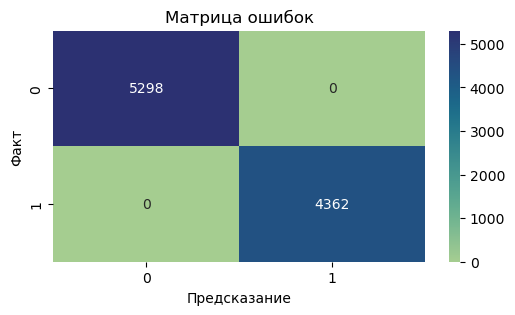

In [86]:
display_cm(y_test, y_pred)

### Настроем модели для оценки.

In [88]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', CatBoostClassifier())
    ]
)
param_grid = [
    {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE, silent=True)],
        'models__learning_rate': [0.01, 0.1, 0.3],
        'models__iterations': [50, 100, 250],             
    },
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [50, 150, 500],
        'models__max_features': ['sqrt', 'log2'],
    },
    {
        'models': [LinearSVC(
                                random_state=RANDOM_STATE,
                                max_iter=500 ,
                    )],
        'models__C': [0.1, 0.5, 1],
    },
    {
        'models': [LogisticRegression(
                                random_state=RANDOM_STATE, 
                                max_iter= 1500,
                                )],
        'models__C': [0.1, 0.5, 1],
    },
]

In [89]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
#    scoring='neg_root_mean_squared_error',
#    cv=tscv,  # Используем TimeSeriesSplit
    scoring=['roc_auc', 'precision', 'recall', 'f1' ],  # Метрики которые будут расчитываться для каждой модели    
    refit = 'f1',      
    n_iter=iter_num,
    verbose = 1,    # уровень логирования
#    n_iter=5,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

### Выберем лучшую модель

In [90]:
%%time
randomized_search.fit(X_train, y_train)

print('Лучшая модель:', randomized_search.best_estimator_)
print('Параметры лучшей модели:', randomized_search.best_params_)
print('Метрика F1-score на тренировочных данных:', abs(round(randomized_search.best_score_,4)))
print('')

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Лучшая модель: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['year', 'month', 'day',
                                                   'day_of_week',
                                                   'message_length_text',
                                                   'message_length_title',
                                                   'words_count_text',
                                                   'words_count_title']),
            

In [91]:
df_result = pd.DataFrame(randomized_search.cv_results_)#
display(df_result[['rank_test_f1', 'mean_test_f1', 'mean_test_recall', 'mean_test_precision', 'mean_test_roc_auc', 'mean_fit_time','param_models' ]].sort_values(by = 'rank_test_f1', ascending=True))
#display(df_result)
#display(df_result.info())

,rank_test_f1,mean_test_f1,mean_test_recall,mean_test_precision,mean_test_roc_auc,mean_fit_time,param_models
1,1,1.000000,1.000000,1.000000,1.000000,13.885598,"LinearSVC(max_iter=2000, random_state=42)"
2,1,1.000000,1.000000,1.000000,1.000000,4.368224,"LinearSVC(max_iter=2000, random_state=42)"
3,3,0.999809,1.000000,0.999618,1.000000,112.686338,<catboost.core.CatBoostClassifier object at 0x...
4,4,0.999579,0.999465,0.999694,0.999999,538.947484,<catboost.core.CatBoostClassifier object at 0x...
5,4,0.999579,0.999465,0.999694,0.999999,189.095727,<catboost.core.CatBoostClassifier object at 0x...
6,6,0.997819,0.996332,0.999310,0.999979,263.025287,RandomForestClassifier(random_state=42)
0,7,0.995904,0.994498,0.997318,0.999977,99.336749,<catboost.core.CatBoostClassifier object at 0x...


### Посмотрим на итоговую таблицу результатов.

### Итог обучения моделей.

Две модели смогли преодолеть порог по F1 = 0.75.
* LogisticRegression = 0.770888
* SVC = 0.769793

Обе эти модели показали результаты лучше чем базовая модель DummyClassifier с F1= 0.00

<div class="alert alert-block alert-success">

<b>Успех:</b> Неплохая работа с моделями, расмотренно их большое количество.
</div>


### Проверим лучшую модель

In [ ]:
#best_model = randomized_search
y_pred = randomized_search.best_estimator_.predict(X_test)
show_metrics(y_test, y_pred,3)

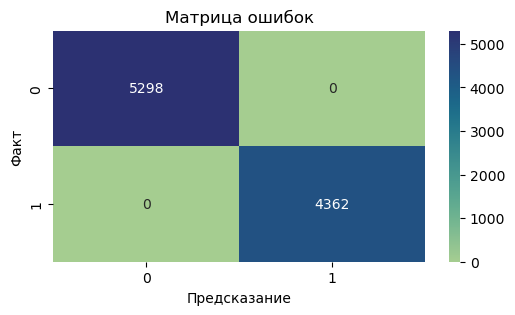

In [110]:
display_cm(y_test, y_pred)

На тестовых данных лучшая модель показала следующие результаты:
* F1_score = 1
* ROC-AUC = 1.0

Это всё скорее настораживает чем радует. Слишком идеально предсказывает модель.

### Итог этапа обучения и проверки модели

* Данные разделены на тестовую и тренеровочную часть
* Проверено несколько моделей с использованием кросс-валидации
* Все модели показали результат по F1-score >0.995
* Все модели показали результат по ROC-AUC >0.999
Это означает переобучение. Скорее всего причиной этого являются специально отобранные исходные данные содержащие много характерных слов в реальном и выдуманном тексте

## Выводы

Было получена два набора данных с реальными и выдуманными новостями. После удаления дублей их осталось 38640 штук. Довольно равномерно распределён целевой признак. 54.8% - правдивых новостей и 45.2% выдуманных. Дисбаланса нет. В пятницу и субботу выдуманных новостей создавалось больше чем реальных. Возможно что после завершения рабочего дня ресурсы ИИ высвобождались для создания и распространения выдуманных новостей.


Топ-10 популярных слов:
* say           
* trump         
* state         
* president     
* people        
* republican    
* year          
* make          
* reuters       
* donald         

Т.е. большая часть новостей о том что кто-то что-то кому-то сказал.
Самые популярные наборы из двух слов:
* donald trump             
* featured image           
* hillary clinton          
* twitter com              
* white house              
* united states            
* pic twitter              
* getty images             
* president obama          
* new york                 

Здусь уже видна политическая направленность новостей.  Судя по датам 2015-2017, новости приходятся на период выбора президента США, в которых победил Дональд Трамп. 

Данные были разделены на тестовую и тренеровочную выборки. Обучена простая модель классификации LogisticRegression. После обучения получены значения:
* ROC-AUC = 1.0
* Precision = 1.0
* Recall = 1.0
* Accuracy = 1.0
* F1_score = 1.0

Или модель идеально угадала, или данные содержат характерные признаки указывающие на реальность или выдуманность новостей.  
После этого для сравнения запущен перебор гиперпараметров для более сложных моделей CatBoostClassifier, RandomForestClassifier, LinearSVC и опять LogisticRegression.
Лучший результат показала модель LinearSVC, со значениями метрик:
* ROC-AUC = 1.0
* Precision = 1.0
* Recall = 1.0
* Accuracy = 1.0
* F1_score = 1.0

Это означает что текущую модель нельзя выпускать в продакшен, она переобученна на "идеальных" данных. Необходимо дополнительно "загрязнить" данные чтобы они стали похожими на новости из реальных СМИ.